# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 45kB/s  eta 0:00:01 7% |██▌                             | 1.1MB 8.9MB/s eta 0:00:02
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

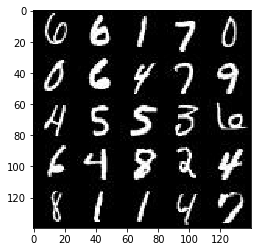

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

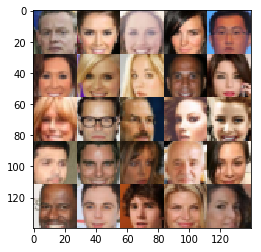

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=()) 

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kinit = tf.contrib.layers.xavier_initializer()
    alpha = 0.01 # for leaky relu
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.maximum(x * alpha, x)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x * alpha, x)
        # 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x * alpha, x)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256)) 
        logits = tf.layers.dense(x, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.contrib.layers.xavier_initializer()
    alpha = 0.01
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        #x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3815... Generator Loss: 3.5756
Epoch 1/2... Discriminator Loss: 0.3702... Generator Loss: 4.9524
Epoch 1/2... Discriminator Loss: 0.4454... Generator Loss: 4.7392
Epoch 1/2... Discriminator Loss: 1.5771... Generator Loss: 8.1834
Epoch 1/2... Discriminator Loss: 0.4221... Generator Loss: 4.2831
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 3.6374
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 2.0783
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 4.2184
Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 3.7284


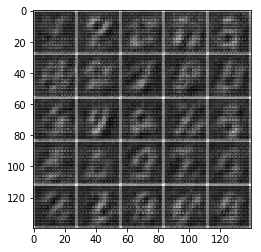

Epoch 1/2... Discriminator Loss: 0.6461... Generator Loss: 1.9607
Epoch 1/2... Discriminator Loss: 0.9203... Generator Loss: 2.4299
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.4509
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 1.1633
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 1.0842
Epoch 1/2... Discriminator Loss: 1.0856... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.6444
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 1.6541
Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 1.3581
Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 1.1466


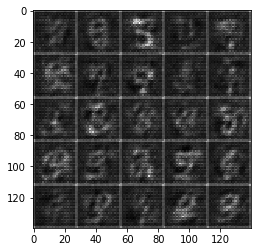

Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 2.1754
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 3.0795
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 1.3005
Epoch 1/2... Discriminator Loss: 0.7208... Generator Loss: 1.4608
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 2.0891
Epoch 1/2... Discriminator Loss: 0.5959... Generator Loss: 2.4588
Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 2.0078
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 0.9865
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 3.3270


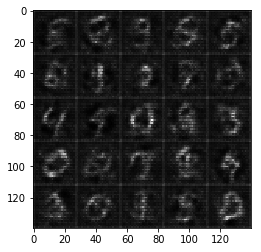

Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.4002
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 1.1489
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.6055
Epoch 1/2... Discriminator Loss: 1.0188... Generator Loss: 0.9092
Epoch 1/2... Discriminator Loss: 0.7400... Generator Loss: 1.5750
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 1.0657
Epoch 1/2... Discriminator Loss: 0.7848... Generator Loss: 1.4487


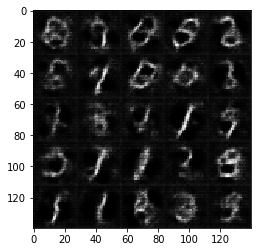

Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 0.8380... Generator Loss: 2.2970
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 1.9428
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 2.6234
Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.4519
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 1.0703
Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 1.2440
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.6915
Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 1.5603


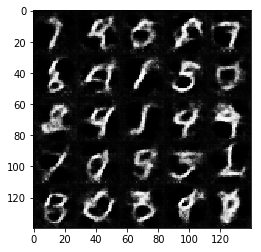

Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 2.0361
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 2.0526
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.4795
Epoch 1/2... Discriminator Loss: 1.8335... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.5029
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 3.2395
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 1.9968
Epoch 1/2... Discriminator Loss: 0.8853... Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 0.7237... Generator Loss: 1.5031


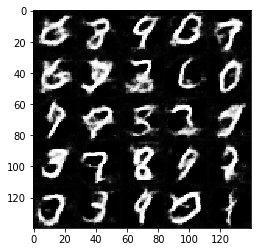

Epoch 1/2... Discriminator Loss: 0.7490... Generator Loss: 1.7069
Epoch 1/2... Discriminator Loss: 0.7702... Generator Loss: 1.7621
Epoch 1/2... Discriminator Loss: 0.8759... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 1.6889
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.7721
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 2.1649
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.3172
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.9653
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.8568
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 1.1562


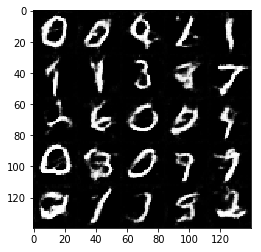

Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 0.7553... Generator Loss: 2.1228
Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 1.2636
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.2803
Epoch 1/2... Discriminator Loss: 0.6318... Generator Loss: 1.9703
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 1.4446
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.0032
Epoch 1/2... Discriminator Loss: 0.6967... Generator Loss: 1.4014
Epoch 1/2... Discriminator Loss: 2.0293... Generator Loss: 0.3170


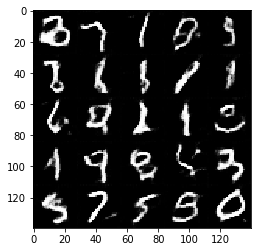

Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.2585
Epoch 1/2... Discriminator Loss: 0.7930... Generator Loss: 1.4502
Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 1.2064
Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 2.3726
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.5030
Epoch 1/2... Discriminator Loss: 0.6595... Generator Loss: 1.7725
Epoch 1/2... Discriminator Loss: 0.6891... Generator Loss: 1.5871
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.5809


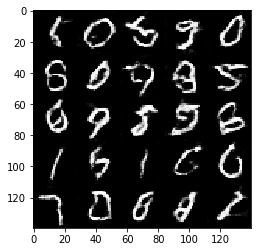

Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.5317
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.7014... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.2540
Epoch 2/2... Discriminator Loss: 0.7720... Generator Loss: 1.2744
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 4.1208... Generator Loss: 5.7413
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 1.0995
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 1.7382


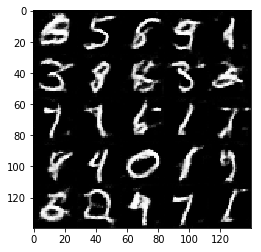

Epoch 2/2... Discriminator Loss: 0.8425... Generator Loss: 1.3957
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 1.0293
Epoch 2/2... Discriminator Loss: 0.9040... Generator Loss: 1.1045
Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 1.9658
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 1.0342
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 1.8711


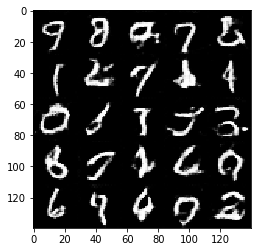

Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 2.3281
Epoch 2/2... Discriminator Loss: 0.6741... Generator Loss: 1.8009
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.5478... Generator Loss: 0.5051
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 1.0961
Epoch 2/2... Discriminator Loss: 1.1572... Generator Loss: 0.7503
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 0.9495
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.8828
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 1.6605


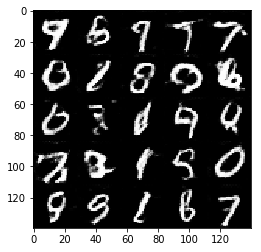

Epoch 2/2... Discriminator Loss: 1.4707... Generator Loss: 0.5264
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 1.9680
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 2.3813
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 1.4794
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.3234
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 1.5470
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.2763
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.9723


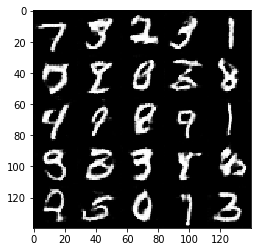

Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.5196
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.5276
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 1.1812
Epoch 2/2... Discriminator Loss: 0.7430... Generator Loss: 1.4251
Epoch 2/2... Discriminator Loss: 1.0279... Generator Loss: 2.3562
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 1.6297
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.5993
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 1.6812
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.0102


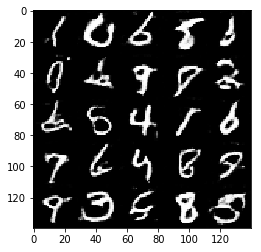

Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.1660
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.2302
Epoch 2/2... Discriminator Loss: 0.7333... Generator Loss: 1.4697
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.3098
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.8949
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 1.5152
Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 1.3989
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 1.8845
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 0.6958


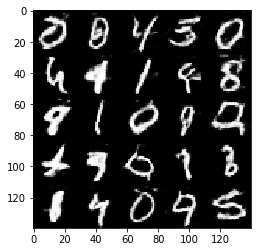

Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 2.1111
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 1.4203
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.6146
Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 1.7721
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.3962
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 1.3309
Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 1.9154
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.0150


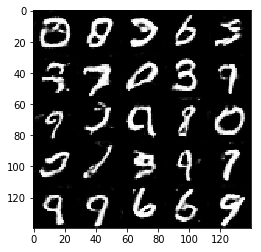

Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.4879
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.6215
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 1.4193
Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 0.7755... Generator Loss: 1.9104
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 1.7314


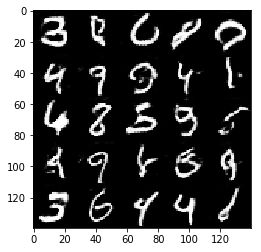

Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 0.7846
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.3023
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.6577
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.6008
Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 1.4304
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 1.0523
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.5315
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.5713


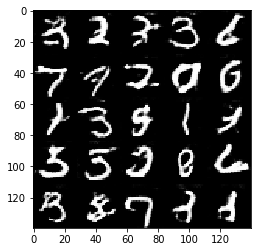

Epoch 2/2... Discriminator Loss: 0.6455... Generator Loss: 1.8332
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.3631
Epoch 2/2... Discriminator Loss: 0.6590... Generator Loss: 2.2929
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.5500
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.9380
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.2473
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.5770


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8685... Generator Loss: 0.3252
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.9888
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.4799
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 2.7905
Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 4.2009
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 6.5390
Epoch 1/1... Discriminator Loss: 3.0708... Generator Loss: 0.2162
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 4.1419


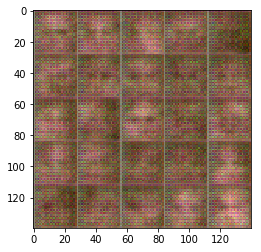

Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 2.0649
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.5466
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 2.3644
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.2841
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 2.7980... Generator Loss: 0.1274
Epoch 1/1... Discriminator Loss: 1.7403... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.6809


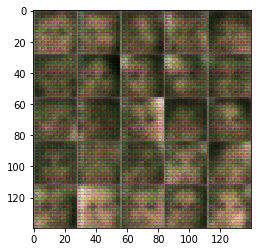

Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 3.1930
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.9898
Epoch 1/1... Discriminator Loss: 1.8081... Generator Loss: 0.2966
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.4161
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 3.3152


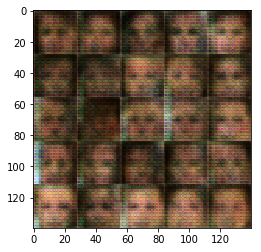

Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 2.2925
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 2.0881
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 4.6063
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 3.9065
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 4.1718
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 3.8388
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.3997


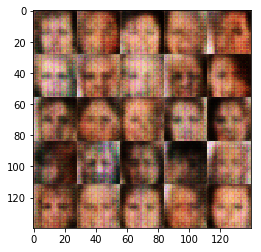

Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 5.0531
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 3.0070
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 6.0585
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 6.5621
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 3.1784
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 3.6444
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.6438


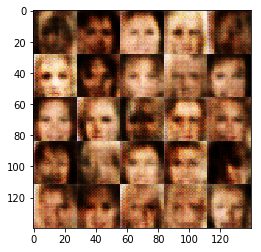

Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 1.9572
Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 3.7020
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 2.2601... Generator Loss: 0.2057
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.9256
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6983


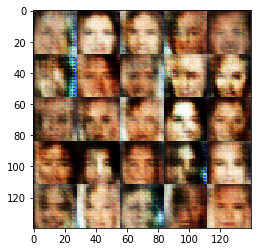

Epoch 1/1... Discriminator Loss: 1.7787... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 4.5547
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 2.5504
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.7752... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.8956


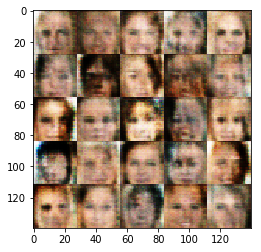

Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.4448
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.7504... Generator Loss: 3.3295
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 3.5563
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.8632
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 2.9039


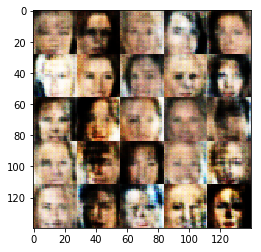

Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 3.5525
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 3.8512
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.7883
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.4663


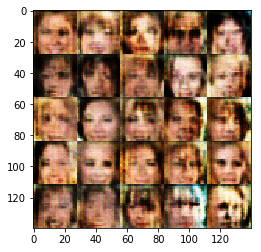

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 4.1732
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 3.0573
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 4.0856
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.7566
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.8586


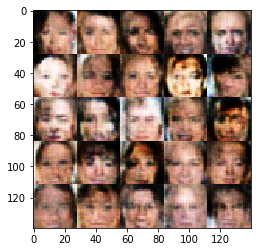

Epoch 1/1... Discriminator Loss: 2.1852... Generator Loss: 0.1903
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 1.6794
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.4587
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.8161
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 3.8248


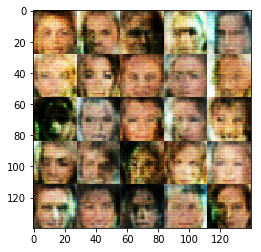

Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 2.8455
Epoch 1/1... Discriminator Loss: 2.1057... Generator Loss: 4.8708
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 1.8667... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 3.2398
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.4584


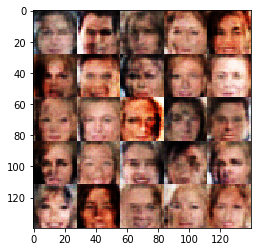

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 5.2792
Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 3.6370
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 3.7445
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 2.1311... Generator Loss: 0.2098


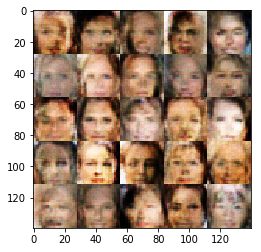

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 1.7576
Epoch 1/1... Discriminator Loss: 2.3437... Generator Loss: 0.1849
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 2.1099... Generator Loss: 0.2302
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.4265
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.7377


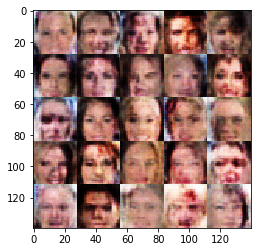

Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 2.3781
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.7332
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.5902
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.8762... Generator Loss: 0.2895
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.9185


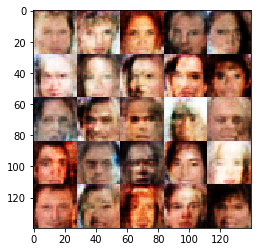

Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 1.4096
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.9154
Epoch 1/1... Discriminator Loss: 2.8134... Generator Loss: 0.1201
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.8769... Generator Loss: 0.2957
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 0.9394


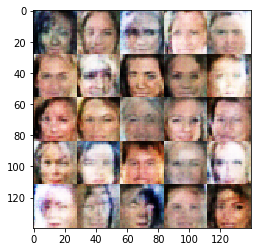

Epoch 1/1... Discriminator Loss: 1.7509... Generator Loss: 0.3200
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.7886
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 2.5063... Generator Loss: 0.1693
Epoch 1/1... Discriminator Loss: 2.2081... Generator Loss: 0.2083
Epoch 1/1... Discriminator Loss: 2.0555... Generator Loss: 0.2269
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 2.1353


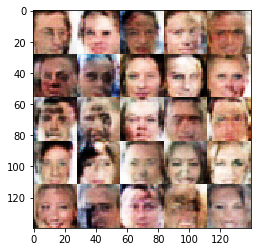

Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 2.9444
Epoch 1/1... Discriminator Loss: 1.6876... Generator Loss: 0.3482
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.7274


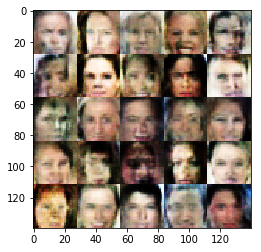

Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 3.5393
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 2.0212
Epoch 1/1... Discriminator Loss: 3.0918... Generator Loss: 0.0877
Epoch 1/1... Discriminator Loss: 1.7439... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.3495
Epoch 1/1... Discriminator Loss: 2.3486... Generator Loss: 0.1828
Epoch 1/1... Discriminator Loss: 1.9744... Generator Loss: 0.2671
Epoch 1/1... Discriminator Loss: 2.2449... Generator Loss: 0.1975
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 2.3280


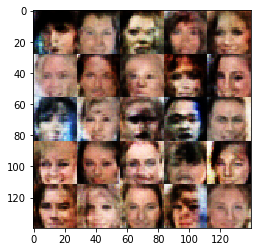

Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.3792
Epoch 1/1... Discriminator Loss: 1.9806... Generator Loss: 3.0693
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 2.3785
Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 4.0565
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.8423
Epoch 1/1... Discriminator Loss: 2.4031... Generator Loss: 2.4463


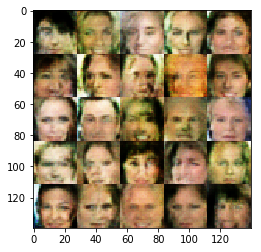

Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 4.3797
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.4094
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.7680
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 3.0756
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 2.4587


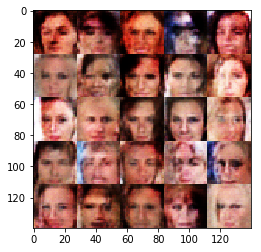

Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.7346
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.9065... Generator Loss: 0.2958
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 2.3732... Generator Loss: 0.1830


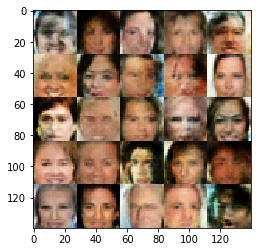

Epoch 1/1... Discriminator Loss: 1.9336... Generator Loss: 0.2892
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 0.3770... Generator Loss: 4.8686
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 2.2701... Generator Loss: 0.1950
Epoch 1/1... Discriminator Loss: 1.9979... Generator Loss: 0.2677
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.5175
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6700


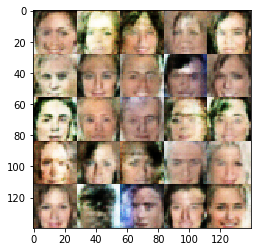

Epoch 1/1... Discriminator Loss: 1.8890... Generator Loss: 0.2780
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 1.3720
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 2.6217
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.6302... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.2621


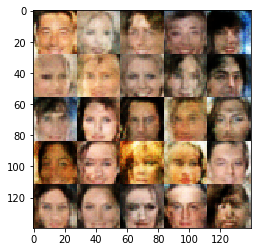

Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 2.8728
Epoch 1/1... Discriminator Loss: 2.1262... Generator Loss: 0.2201
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.9652
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 1.9232
Epoch 1/1... Discriminator Loss: 2.3828... Generator Loss: 0.1742
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.4963


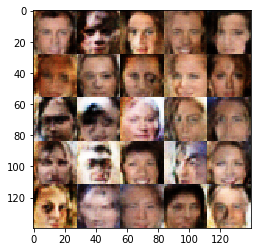

Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.9751... Generator Loss: 0.2835
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 2.5030


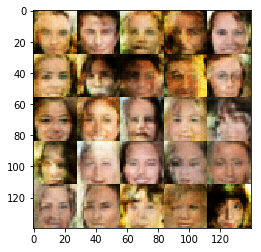

Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 1.8944... Generator Loss: 0.3060
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.8607... Generator Loss: 0.2835
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 1.7644
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 2.3539
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 3.2876... Generator Loss: 0.0845


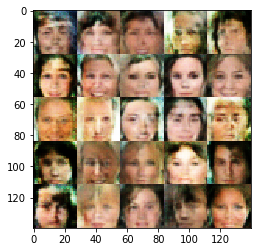

Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 2.6292
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 2.8749
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 3.3265
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 2.4620
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 2.3453
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.3204


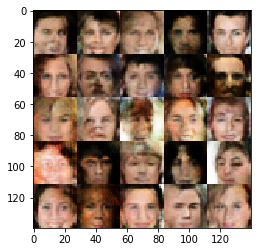

Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.3418
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 1.7167
Epoch 1/1... Discriminator Loss: 1.9654... Generator Loss: 0.3257
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.2532


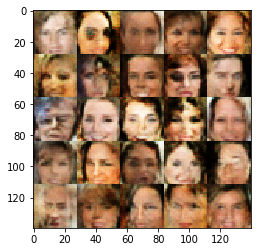

Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 2.0736... Generator Loss: 2.5789
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.5013


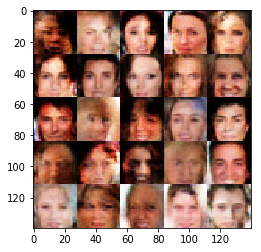

Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 2.4469... Generator Loss: 0.1528
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.3531
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.4501


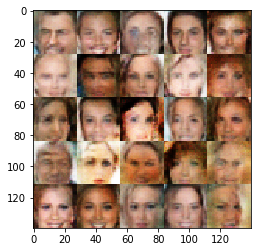

Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.4253
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 2.1337
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 2.4041
Epoch 1/1... Discriminator Loss: 1.8004... Generator Loss: 0.3056
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 2.0861
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.6943


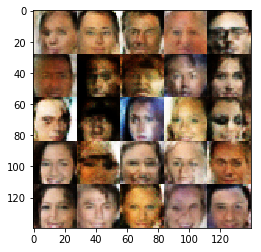

Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.3816
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 1.9330
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.9925


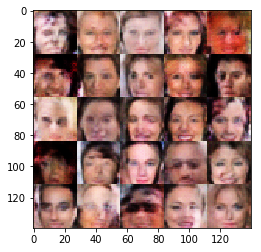

Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.5942
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 3.5346
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.8251
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8314


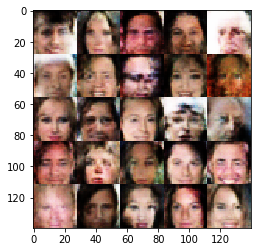

Epoch 1/1... Discriminator Loss: 2.5657... Generator Loss: 0.1361
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 2.0492... Generator Loss: 0.2628
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 1.7660
Epoch 1/1... Discriminator Loss: 2.2107... Generator Loss: 1.9934
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.4659


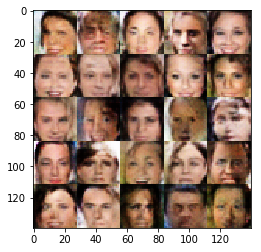

Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.3819
Epoch 1/1... Discriminator Loss: 2.7135... Generator Loss: 0.1387
Epoch 1/1... Discriminator Loss: 1.8449... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.9819... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.5781


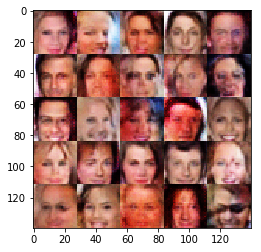

Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 2.2944
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.8316
Epoch 1/1... Discriminator Loss: 2.2367... Generator Loss: 4.0903
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.4072


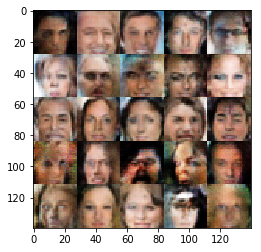

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.9937... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.7382... Generator Loss: 2.1453
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.2409


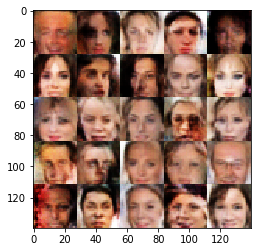

Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 1.4230
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.8860... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 2.0548
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.2304


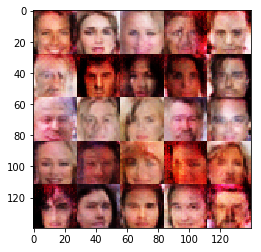

Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 0.4109
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.9823
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 2.5841... Generator Loss: 0.1696
Epoch 1/1... Discriminator Loss: 1.7040... Generator Loss: 0.3292
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 2.4678


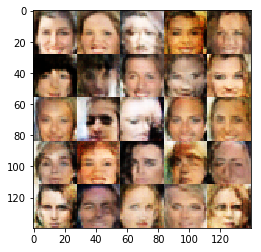

Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.9338
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.6076
Epoch 1/1... Discriminator Loss: 2.0119... Generator Loss: 2.8613
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.6053


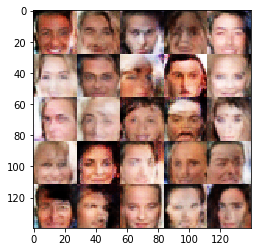

Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.6447
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 3.0833
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 2.2440
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.6409... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 1.5884
Epoch 1/1... Discriminator Loss: 1.7426... Generator Loss: 1.8871


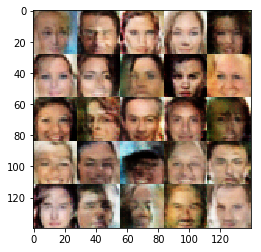

Epoch 1/1... Discriminator Loss: 1.8444... Generator Loss: 0.2860
Epoch 1/1... Discriminator Loss: 1.6902... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 1.7309... Generator Loss: 0.3400
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 2.2303... Generator Loss: 0.1964
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 2.6254... Generator Loss: 0.1489
Epoch 1/1... Discriminator Loss: 2.7616... Generator Loss: 0.1503
Epoch 1/1... Discriminator Loss: 2.3252... Generator Loss: 0.2112
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.8036


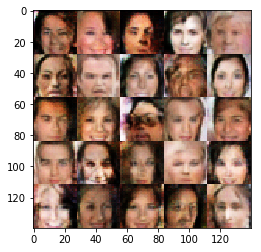

Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 2.8199
Epoch 1/1... Discriminator Loss: 2.4177... Generator Loss: 0.1721
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.5358
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.8004
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.7577... Generator Loss: 0.3141


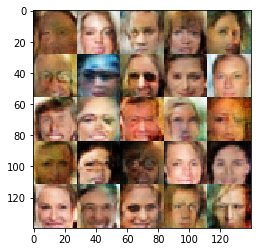

Epoch 1/1... Discriminator Loss: 2.3148... Generator Loss: 0.1742
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.8854... Generator Loss: 0.2731
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.3534
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 2.2033
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 2.3621
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.4551


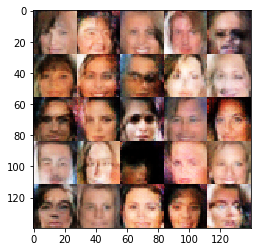

Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 1.7366
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 1.7723... Generator Loss: 0.3371
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 2.2169... Generator Loss: 0.2024
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 2.0229... Generator Loss: 0.2446
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 2.0948


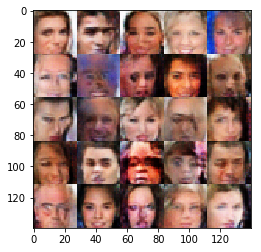

Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.3542
Epoch 1/1... Discriminator Loss: 1.8955... Generator Loss: 0.3041
Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.6977
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 2.0758
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.5977


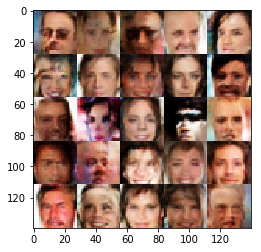

Epoch 1/1... Discriminator Loss: 1.7375... Generator Loss: 0.3239
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 2.1599... Generator Loss: 0.2131
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.4355


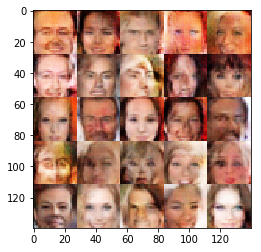

Epoch 1/1... Discriminator Loss: 2.6062... Generator Loss: 0.1467
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 2.5597... Generator Loss: 0.1516
Epoch 1/1... Discriminator Loss: 1.7781... Generator Loss: 0.3267
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.8557
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 2.2142
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.4863


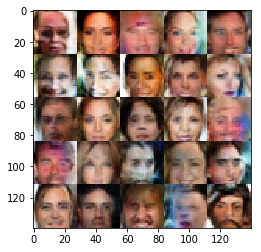

Epoch 1/1... Discriminator Loss: 1.9985... Generator Loss: 0.2664
Epoch 1/1... Discriminator Loss: 1.8031... Generator Loss: 0.3055
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 2.0504... Generator Loss: 0.2624
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 2.2586... Generator Loss: 0.1882
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.6995... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 2.1977... Generator Loss: 0.2088


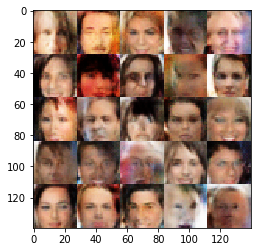

Epoch 1/1... Discriminator Loss: 1.9014... Generator Loss: 0.2803
Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 0.3107
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.9433
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.2521
Epoch 1/1... Discriminator Loss: 1.7323... Generator Loss: 0.3482
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.5620
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 2.4019... Generator Loss: 0.1731
Epoch 1/1... Discriminator Loss: 2.3379... Generator Loss: 0.1804
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.6386


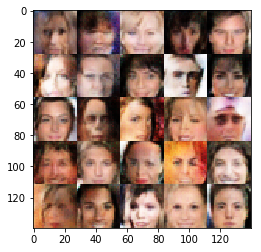

Epoch 1/1... Discriminator Loss: 1.7136... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.0950
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.7704... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 2.1182
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 2.0396... Generator Loss: 0.2309


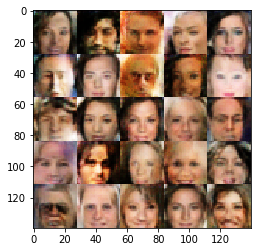

Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.6272
Epoch 1/1... Discriminator Loss: 2.1759... Generator Loss: 0.2164
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.9066
Epoch 1/1... Discriminator Loss: 2.4035... Generator Loss: 0.1723
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.2947
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.0345


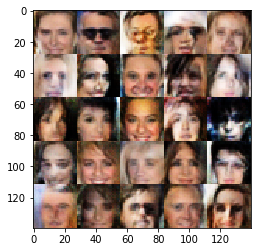

Epoch 1/1... Discriminator Loss: 2.3825... Generator Loss: 0.1803
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.8431... Generator Loss: 0.3019
Epoch 1/1... Discriminator Loss: 1.7652... Generator Loss: 0.3493
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.7753


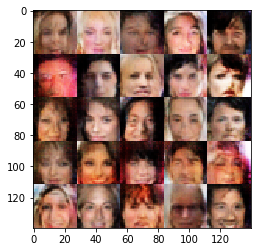

Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 2.0179... Generator Loss: 0.2644
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 2.3765... Generator Loss: 0.1745
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.6303... Generator Loss: 0.3703
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 2.1275... Generator Loss: 0.2449


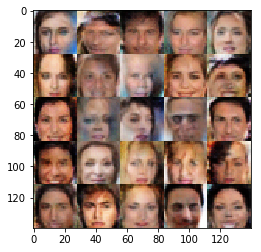

Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.7395... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 2.1290... Generator Loss: 0.2102
Epoch 1/1... Discriminator Loss: 2.0008... Generator Loss: 0.2698
Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.7745


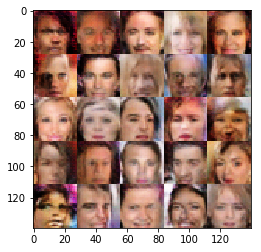

Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.7383
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.9177... Generator Loss: 0.2551
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 2.0340... Generator Loss: 0.2419
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 0.4205


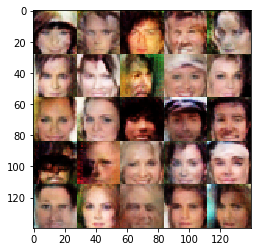

Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.5860
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.7243... Generator Loss: 0.3311
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.9075... Generator Loss: 0.3162
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 2.1430... Generator Loss: 0.2508
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.6917


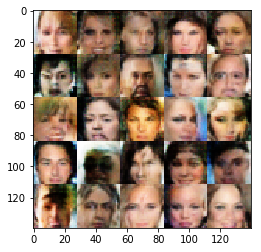

Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 2.1534... Generator Loss: 0.2205
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.9181


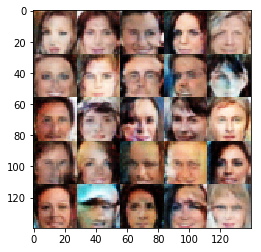

Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.8247
Epoch 1/1... Discriminator Loss: 2.4599... Generator Loss: 0.1466
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 2.8307... Generator Loss: 0.1266
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 2.3686
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.9774... Generator Loss: 0.2564


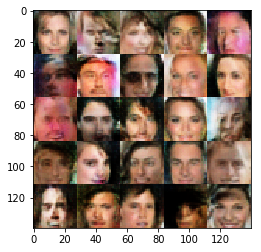

Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.3773
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 2.4014... Generator Loss: 0.1857
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.7331... Generator Loss: 0.3809


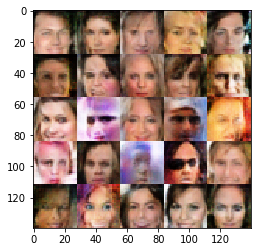

Epoch 1/1... Discriminator Loss: 2.4416... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 2.1502... Generator Loss: 0.2170
Epoch 1/1... Discriminator Loss: 3.5445... Generator Loss: 0.0544
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 2.1679... Generator Loss: 0.1984
Epoch 1/1... Discriminator Loss: 1.8304... Generator Loss: 0.3072
Epoch 1/1... Discriminator Loss: 2.4798... Generator Loss: 0.1469
Epoch 1/1... Discriminator Loss: 2.2371... Generator Loss: 0.2213


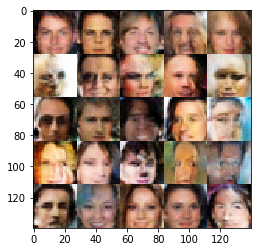

Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.6452... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.7390... Generator Loss: 0.3199
Epoch 1/1... Discriminator Loss: 1.7595... Generator Loss: 0.3276
Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.8023


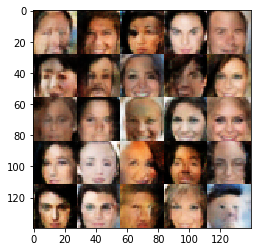

Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.4345


In [13]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.2
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.